In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd.functional import jacobian
import tqdm
from tqdm import notebook
import random
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
import matplotlib.pyplot as plt

In [4]:
dev ='cuda'

In [5]:
torch.set_default_dtype(torch.float64)
torch.set_default_device(dev)

In [6]:
def G(gs):
    '''
    :param gs: a list of tensor functions
    :return: a function sending a tensor to the stacked matrix of the functions of that tensor
    '''
    def G_gs(tensor):
        x = torch.squeeze(tensor)
        # print("Function input: ",tensor) # checking the input for debugging
        # print("Function output:" , torch.stack([g(tensor) for g in gs],0))
        return torch.stack([g(x) for g in gs], 0)

    return G_gs

def J(gs, x):
    '''Returns the Jacobian evaluated at x for a list gs of constraint functions'''
    return jacobian(G(gs), torch.squeeze(x), create_graph = True, vectorize=True)

In [7]:
bones2 = [
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (11, 12),
    (12, 13),
    (13, 14),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [8]:
def cotangent_projection(gs):
    def proj(x):
        G = J(gs,x)
        number = torch.inverse(G @ G.T)
        matrix = G.T @ G
        M = torch.eye(3)
        L= torch.eye(3) - G.T @ G *number
        return L
    return proj

In [9]:
class ScoreNet(nn.Module):
  """A time-dependent score-based model."""


  def __init__(self, embed_dim):
    super().__init__()
    self.lin1 = nn.Linear(3,75)
    self.lin2 = nn.Linear(75, 75)
    self.lin3 = nn.Linear(75, 75)
    self.lin4 = nn.Linear(75, 3)
    #self.lin5 = nn.Linear(57,57)
    self.act = torch.nn.Tanh()
    # Initializing the weights with the Xavier initialization method
    torch.nn.init.xavier_uniform_(self.lin1.weight)
    torch.nn.init.xavier_uniform_(self.lin2.weight)
    torch.nn.init.xavier_uniform_(self.lin3.weight)
    torch.nn.init.xavier_uniform_(self.lin4.weight)

  #@torch.compile(mode="default")
  def forward(self,x,L):

      h = self.lin1(x)
      h = self.act(self.lin2(h))
      h = self.act(self.lin3(h))
      h = self.lin4(h)
      #h = self.act(self.lin5(h))

      # projection

      p = torch.unsqueeze(L@ torch.squeeze(h),0)
      h = p

      # NOT normalizing the output
      #h = h/ t[:,None]

      # setting the force on the fixed point to zero
      return torch.squeeze(h)

In [10]:
score_model = ScoreNet(58)
# ckpt = torch.load('ckpt_moser_sphere24.pth')
# score_model.load_state_dict(ckpt)


In [11]:
from torch.utils.data import TensorDataset, DataLoader

In [12]:
from torch.optim import Adam

In [13]:
import warnings
warnings.filterwarnings("ignore")


In [14]:
#ckpt = torch.load('ckpt_moser_sphere3.pth')
score_model.train()
#score_model.load_state_dict(ckpt)

ScoreNet(
  (lin1): Linear(in_features=3, out_features=75, bias=True)
  (lin2): Linear(in_features=75, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=75, bias=True)
  (lin4): Linear(in_features=75, out_features=3, bias=True)
  (act): Tanh()
)

In [15]:
#torch._dynamo.config.verbose=True

In [16]:
#torch._dynamo.config.suppress_errors = True

# Sampling from the reverse SDE

In [17]:
pos = np.load('positions_gamma_7.npy',allow_pickle=True)[0::50]

In [18]:
np.random.shuffle(pos)

In [19]:
pos_list = [p for p in pos]
pos_tensor = torch.stack(pos_list)

In [20]:
len(pos_tensor)

20000

In [21]:
data_tensor = pos_tensor

In [22]:
data_tensor[0].size()

torch.Size([3])

In [23]:
data_tensor = torch.stack([torch.flatten(tens) for tens in data_tensor])

In [24]:
my_dataset = TensorDataset(data_tensor[400:])
test_dataset = TensorDataset(data_tensor[:400])

In [25]:
def mu_minus(eps, x):
    return nn.functional.relu(-x + eps)

def mu_plus(eps, x):
    return nn.functional.relu(x - eps) + eps

In [26]:
#@title Define the loss function (double click to expand or collapse)
def loss2(model, xs,eps=torch.tensor([1e-15]), lam =1):
    """The loss function for moser flows
    """
    # xs is a batch (batch_size, 57) of position
    loss = torch.tensor([0.])


    # first the loss for the first part
    for point in xs:
        # x is the list of simulated qs
        gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2 -1]
        L_fn = cotangent_projection(gs)
        
        def find_score(x):
            L = L_fn(x)
            score = model(x,L).to(dev)
            return score
        
        sim_x = torch.unsqueeze(point,0)
        divergence1 = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(find_score, inputs=(sim_x), create_graph=True)))
        #print(f"DIV1 = {divergence1}")
        exp = mu_plus(eps, 1/(4*torch.pi) - divergence1)
        loss = loss - torch.log(exp)/len(xs)
        
    # and now the positivity loss
    for i in range(100):
        theta= torch.rand(1)*torch.pi*2
        phi = torch.acos(2*torch.rand(1) -1)
        x = torch.tensor([torch.sin(theta)*torch.cos(phi),torch.sin(theta)*torch.sin(phi),torch.cos(theta)])
        gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2 -1]
        L_fn = cotangent_projection(gs)

        def find_score(x):
            L = L_fn(x)
            score = model(x,L).to(dev)
            return score
        
        sim_y = torch.unsqueeze(x, 0).detach().clone()
        sim_y.requires_grad_()
        divergence = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(find_score, inputs=(sim_y), create_graph=True,strict =False, vectorize=False)))
        l = mu_minus(eps, 1/(4*torch.pi) - divergence)
        loss = loss + (lam/100) * (l)*(4*torch.pi)
    return loss

In [27]:
#xs = np.arange(0,len(epoch_losses),len(epoch_losses)//len(test_losses))
#plt.plot(xs[1:],test_losses, color = 'blue', label = 'Test data loss')
plt.plot(epoch_losses, alpha = 0.5, label = 'Loss per batch')
plt.xlabel('Batch number', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Losses in neural network training', fontsize = 25)
plt.legend(fontsize = 12)
plt.savefig('training_sphere_moser.pdf')

NameError: name 'epoch_losses' is not defined

In [28]:
import matplotlib.pyplot as plt

In [29]:
score_model.eval()

ScoreNet(
  (lin1): Linear(in_features=3, out_features=75, bias=True)
  (lin2): Linear(in_features=75, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=75, bias=True)
  (lin4): Linear(in_features=75, out_features=3, bias=True)
  (act): Tanh()
)

In [30]:
for i in range(100):
    theta= torch.rand(1)*torch.pi*2
    phi = torch.acos(2*torch.rand(1) -1)
    x = torch.tensor([torch.sin(theta)*torch.cos(phi),torch.sin(theta)*torch.sin(phi),torch.cos(theta)])
    x.requires_grad_()
    gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2-1]
    L_fn = cotangent_projection(gs)

    def find_score(x):
        L = L_fn(x)
        score = score_model(x,L).to(dev)
        return score
    
    sim_x = torch.unsqueeze(x,0)
    sim_x.requires_grad_()
    L = L_fn(sim_x)
    torch.autograd.functional.jacobian(find_score, inputs=(sim_x))
    print(density(sim_x,L))

NameError: name 'density' is not defined

In [31]:
def get_density(x):
    gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2-1]
    L_fn = cotangent_projection(gs)
    L = L_fn(x)
    return density(x,L)

In [32]:
from matplotlib import cm, colors
from matplotlib.colors import Normalize

In [33]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm


phi = np.linspace(0, np.pi, 30)
theta = np.linspace(0, 2*np.pi, 30)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)


m, l = 2, 3


# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
#fcolor = pi_1(x,y)



# Set the aspect ratio to 1 so our sphere looks spherical

colormap = plt.cm.viridis

scalar_values = np.zeros_like(x)
for i in range(len(x)):
    for j in range(len(x)):
        scalar_values[i][j] = get_density(torch.tensor([x[i][j], y[i][j], z[i][j]], device =dev)).detach().cpu().numpy()
        
norm = Normalize(scalar_values.min(), scalar_values.max())


# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.jet(norm(scalar_values)))
ax.set_xticks([-1,-.75,-.5,-.25,0,.25,.5,.75,1])
ax.set_zticks([-1,-.75,-.5,-.25,0,.25,.5,.75,1])

m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
m.set_array([])
plt.colorbar(m)

# Turn off the axis planes
#ax.set_axis_off()
plt.savefig("globe_1.pdf")

NameError: name 'density' is not defined

In [34]:
def get_theta(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)* np.sin(phi)
    z = np.cos(theta)
    t = torch.tensor([x,y,z])
    return get_density(t)*theta**2 *np.sin(theta)

In [35]:
def get_phi(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)* np.sin(phi)
    z = np.cos(theta)
    t = torch.tensor([x,y,z])
    return get_density(t)*phi**2 *np.sin(theta)

In [36]:
from scipy.integrate import dblquad

In [37]:
dblquad(get_theta, 0, 2*np.pi, 0, np.pi)

NameError: name 'density' is not defined

In [ ]:
dblquad(get_phi, 0, 2*np.pi, 0, np.pi)

In [ ]:
plt.plot(epoch_losses)

In [38]:
## size of a mini-batch
## learning rate
lr=1e-6 #@param {'type':'number'}
batch_size =  16 #@param {'type':'integer'}
## learning rate
dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True)
n_epochs = 20
tqdm_epoch = tqdm.notebook.trange(n_epochs)
optimizer = Adam(score_model.parameters(), lr=lr)
i = 0
for epoch in tqdm_epoch:
    t_dl =tqdm.tqdm(dataloader)
    avg_loss = 0.
    num_items = 0
    for pw in t_dl:
        x = pw[0].to(dev)
        i += 1
        loss = loss2(score_model, x)
        t_dl.set_description(f"Loss = {loss.item()}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        epoch_losses.append(avg_loss / num_items)
        gradient = torch.gradcheck(score_model, x)
        print(f"Gradient = {gradient}")
        break
    plt.plot(epoch_losses)
    plt.show()
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'ckpt_improved.pth')

  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/1225 [00:00<?, ?it/s]


RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

In [ ]:
score_model.eval()

In [39]:
x = torch.rand(57)
x.requires_grad_()

tensor([0.1445, 0.0443, 0.4600, 0.2960, 0.8372, 0.9435, 0.4724, 0.4558, 0.2135,
        0.9030, 0.5582, 0.9177, 0.6795, 0.4840, 0.3558, 0.9995, 0.1507, 0.0453,
        0.6470, 0.2204, 0.1394, 0.7463, 0.3540, 0.0503, 0.9941, 0.2414, 0.6386,
        0.0280, 0.3966, 0.2039, 0.6464, 0.5624, 0.8697, 0.4153, 0.9256, 0.2975,
        0.8287, 0.3645, 0.9172, 0.9938, 0.4155, 0.2050, 0.2250, 0.5657, 0.4934,
        0.8851, 0.6754, 0.0017, 0.6900, 0.1128, 0.1638, 0.3080, 0.6531, 0.0245,
        0.2477, 0.4118, 0.4314], device='cuda:0', requires_grad=True)

In [40]:
def phi_dens(theta,phi):
    x = 

SyntaxError: invalid syntax (1121974717.py, line 2)

# generating a uniform position

In [ ]:
q=data_tensor[0]

In [ ]:
score_model.eval()

In [45]:
bones = [
    (0, 1),
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]

def angles_to_joints(angles, lengths,bones):
    pose = torch.zeros((19,3))
    pose[0] = torch.tensor([0,0,2])
    for i in range(len(bones)):
        bone = bones[i]
        r = lengths[i]
        phi = torch.tensor(angles[i][0])
        theta = torch.tensor(angles[i][1])
        pose[bone[1]] = pose[bone[0]] + torch.tensor([r*torch.sin(theta)*torch.cos(phi),r*torch.sin(theta)*torch.sin(phi),r*torch.cos(theta)])
    return pose

def lengths(bones,poses):
    lengths = []
    poses = torch.squeeze(poses).reshape((19,3))
    for bone in bones:
        l = poses[bone[0]] -poses[bone[1]]
        l = torch.sqrt(torch.dot(l,l))
        lengths.append(l)
    return lengths

def uniform_generator(x_init,bones):
    random_angles = torch.vstack([torch.rand(18)*torch.pi*2,torch.acos(2*torch.rand(18) -1)]).T
    lengths1 = lengths(bones, x_init)
    return angles_to_joints(random_angles,lengths1,bones)

In [46]:
### now finding the density
def density(x,L):
    divergence = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(score_model, inputs=(x,L), create_graph=True,strict=True)))
    return 1/(4*torch.pi)**(18) - divergence

In [53]:
### now finding the density
def div(x,L):
    divergence = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(score_model, inputs=(x,L), create_graph=True,strict=True)[0]))
    return 1 - divergence

In [68]:
# I need to find the divergence of a slightly different function
gs = [lambda x: x[0]**2 + x[1]**2 + x[2]**2 -1]
L_fn = cotangent_projection(gs)
def fn(x):
    L = L_fn(x)
    return score_model(x,L)

### now finding the density
def div(x):
    divergence = torch.trace(torch.squeeze(torch.autograd.functional.jacobian(fn, inputs=(x), create_graph=True,strict=True)))
    return 1 - divergence

In [71]:
ds = 0
avgs = []
for i in range(1,10000):
    theta= torch.rand(1)*torch.pi*2
    phi = torch.acos(2*torch.rand(1) -1)
    x = torch.tensor([torch.sin(theta)*torch.cos(phi),torch.sin(theta)*torch.sin(phi),torch.cos(theta)])
    sim_x = torch.unsqueeze(x,0)
    ds += div(sim_x).item()
    avgs.append(ds/i)
    print(ds/i)

-0.03540579525402321
0.3065613013466561
0.409885636076182
0.9212650106018824
1.101555785012113
0.8521178483997431
0.7984327853159485
0.741589500594047
0.9837371467153216
1.1193948901157509
1.1179556836766191
1.0957309162963187
1.089722110408157
1.006601717852073
1.055223460757145
1.004253413397187
1.0026640818756363
0.9444038584788265
0.9290987296997244
0.8666078258541337
0.8368276627564233
0.8693881466584125
0.9088447883351738
0.8977103777280617
0.8807288043661008
0.927514059943914
0.8912966435461681
0.8689384577285191
0.8955220673380245
0.9697609135358893
0.9383028379741637
0.9173834161225486
0.8943972978717226
0.8665844462286761
0.8767425144324843
0.8665382641629019
0.8662764237990241
0.8900724199685476
0.8670475953704476
0.8577203241417672
0.8492215862566928
0.8199410746691476
0.8088767940092952
0.8668718871120695
0.8718134462743524
0.9129011304620345
0.9107129824472308
0.884834798741827
0.9262664327026319
0.9039171929018714
0.8850309035517425
0.8673458378870902
0.8636788721000223


0.9888459358305707
0.9880606408377569
0.9866476784177658
0.9843334191225311
0.9877627866293066
0.9904055391690758
0.9884865032635688
0.9927906889762019
0.9907919087709937
0.98787662618876
0.9858526970477189
0.9842514645409164
0.9892065348248731
0.9882681619757802
0.987705353016772
0.9876863936391018
0.9898989240699018
0.9912939259650022
0.9919026380877507
0.9912290077659464
0.9907157187751039
0.9954917255324306
0.9932138131537646
0.99170169492366
0.9960608008992585
0.9966107896378897
0.9946929969793231
0.9942735409552674
0.9939847726784762
0.996169810714076
1.0004001131261386
1.0007486185482988
1.0012887148361074
1.0047382672475629
1.0025667671210812
1.0065989222304035
1.009096210983017
1.0128305987918829
1.016709610291426
1.0186593429565824
1.0221675340939398
1.026925950900388
1.030991278492928
1.0305884836934296
1.0295031751286678
1.02973080971902
1.0276225724466748
1.0256949715283146
1.0254604869384274
1.0236694751164923
1.024305581487272
1.0242357402983016
1.0218320650274253
1.0194

1.0321361230903436
1.033905682920227
1.0326224600174592
1.0316531713836483
1.030475740987538
1.0312077827968251
1.0315632406286586
1.0304391371475585
1.0292336969734504
1.0303819863609283
1.0295115483676687
1.0296738007396942
1.0291324990826303
1.0275454790798066
1.0272424424837423
1.026479960846665
1.0254421725705989
1.0262251632303603
1.0288510039727665
1.0281434085549146
1.0273393564416893
1.026235861264197
1.0256651439797342
1.027766181487304
1.0264477498416669
1.0253885601379493
1.0255731327426905
1.0242526064220954
1.0232736340168567
1.022947080472121
1.0223775556300525
1.0218755877757377
1.022409339015761
1.0222362648161967
1.0245558875572476
1.0242421664295165
1.0245086723157069
1.0247662206807704
1.0237310673676074
1.0232911529703275
1.025024580673423
1.0243287836381934
1.0267865194923658
1.0264690449774359
1.0253806559149694
1.0242943160847784
1.0231664410542265
1.0235303498257635
1.022805372164644
1.0230221715784706
1.021535263374521
1.0233777880451054
1.0231726158645007
1.0

1.0341689189165113
1.0337854488841494
1.0330162230259428
1.0346959059219871
1.034292899429896
1.0344144747301194
1.0337028771281718
1.03388103865045
1.0332834305404774
1.0333211438526166
1.0327049720463461
1.0318953726865823
1.031077744793658
1.0315261119683339
1.0326598020187479
1.031848621941351
1.0316896335986323
1.0310362864132994
1.0304667190242358
1.0302012836544308
1.0299668136808688
1.0293420380809846
1.0285039387157555
1.028684841872446
1.0300395871023138
1.0317096786224005
1.0308805434184931
1.0308372643592827
1.0304708227663617
1.0303860309145674
1.0295772076687568
1.0290068295689534
1.0305351370405633
1.0298232024449856
1.031004921947919
1.0305175699950293
1.030073582464585
1.0307779053596586
1.031482492847151
1.0327651381133647
1.0322537917278636
1.0320821058793643
1.0318307002479663
1.031374243572016
1.0321496878162013
1.0318695409173186
1.0312197124813196
1.0306889117759899
1.0306869403054706
1.03044839520868
1.0297743716788463
1.0294972473594595
1.0291732323385396
1.028

1.0361215175703964
1.036147956766643
1.0361675517941495
1.0355725038557884
1.0358571176122673
1.0350916078625774
1.0350956255069617
1.035611826042967
1.0353239371686977
1.0348017375075942
1.0345732092537918
1.0340986451143657
1.033818454620407
1.0337976060930074
1.033886667254888
1.033656012705844
1.03329996624229
1.0338665049949165
1.0330717614934712
1.0341900888913211
1.035024926933726
1.0345070686206428
1.0355365753515475
1.0350002983090283
1.0353906668808488
1.0349723911011866
1.034398187442389
1.0340102569098002
1.0349690953450112
1.0341891406479313
1.0335830509191968
1.0332915706356658
1.0337413772114878
1.0346649065223623
1.033928529762146
1.033610910359858
1.0332162354717012
1.0327248479814692
1.0326193903842495
1.0318086936201758
1.0317919294293825
1.0313171174798177
1.0309084727085813
1.0320736313134757
1.0322571597249626
1.0315445989452192
1.0311612307123281
1.0317706343012054
1.0315913722911763
1.0312114197625193
1.0312834260605988
1.0319316704633956
1.0313741905324645
1.03

1.0286894375042952
1.0287621834296334
1.0295981330608228
1.0293401797901374
1.028949033003835
1.0287814843588374
1.0282317841834447
1.0282175196092154
1.028030022022439
1.0279878866685779
1.0278713227263239
1.027747335338216
1.0273161251413188
1.0268320902284873
1.0264523120766817
1.0271378707270722
1.0267686005435617
1.0263956242194285
1.0266582721921578
1.0268016755378306
1.0266213572782268
1.0265110019506345
1.0271876008118435
1.026560182587899
1.025925894479076
1.025623995063099
1.0250409151963216
1.0252347674271889
1.025666829642529
1.0252038170971545
1.0249119088863132
1.024781336786709
1.024974940462775
1.0249087724360568
1.0249846532960545
1.0247433485506097
1.0244894591206362
1.0255268073708088
1.026144207426086
1.0266503590997333
1.0272177497200163
1.0278209049544282
1.028399613994953
1.0280893034735001
1.0288541339725885
1.0283183783631635
1.0288556861046518
1.0289567833175923
1.029252174036341
1.0296458189288464
1.0294937315257628
1.0302518122247089
1.0304197039893221
1.030

1.030993947625591
1.0315968891359968
1.0315352732679761
1.0312549556357913
1.0307471446424328
1.0313363720312272
1.0312513651896875
1.0319573955322745
1.0314991069335433
1.0311924275952222
1.0309265488451793
1.030618268102811
1.0304540180399802
1.0309528376864792
1.0306593258506276
1.030287321295249
1.0298762222331919
1.0303827377957975
1.0312242843178332
1.0317286726909196
1.032326340637631
1.0324721857978627
1.0321018097409085
1.031931192691542
1.0318472190243388
1.0318716850080978
1.032667622274824
1.0332608022925542
1.0333024109464986
1.033178670877287
1.032793225188081
1.032459842066491
1.0320595864056745
1.0319284255992212
1.031758561630889
1.0312832684667044
1.0308248127224087
1.030478239333715
1.0304034037222736
1.0306274352142097
1.0314248534841568
1.0313199707300773
1.0309605564098812
1.0305263784333971
1.030248256128659
1.0298265199463263
1.029747102606677
1.0294770425725321
1.0291305764703478
1.0293661634558067
1.029493683685786
1.0292927106083174
1.0296636570050153
1.02975

1.0186535952945743
1.018593840896633
1.018410699348048
1.0184919441286202
1.0189891984329147
1.0186434675239477
1.018318964250135
1.0178575899573163
1.0175334023549147
1.017236648552833
1.0175404829100512
1.017261645712041
1.016985019513491
1.0172433851790945
1.017645173717236
1.0175382203305625
1.0181022002530555
1.0176346945153516
1.0176459157744264
1.0175230601282546
1.0177362509847643
1.0173637466076026
1.0172814128950423
1.0177446193173647
1.0183787341364938
1.0184945728271169
1.0182272862649246
1.0181215503322438
1.0182250891836433
1.0178244153480347
1.0175093973530251
1.0174518288323722
1.0173509543323043
1.017007367810173
1.0170542691593643
1.0168370165536493
1.0167081605880106
1.0167471052212231
1.0173945313105375
1.0171877141566967
1.0169982991615263
1.0167520257602516
1.0164810378282134
1.016521566569684
1.016734144066953
1.0165664772939167
1.0167065228450685
1.0167481803931908
1.0172540929484646
1.0171645813414165
1.016932081366988
1.0169295775060745
1.0175508456365467
1.01

1.0154701142309372
1.015497331339113
1.0151053158870265
1.0149189768090023
1.015585637193734
1.0153168516113258
1.0152946372480969
1.0155197861860759
1.0153104504258266
1.015863524100781
1.0156955009908957
1.015826433293894
1.0164282961874647
1.0170446279639918
1.0176083831734473
1.0174327295585506
1.0179228098010478
1.0182026880278914
1.0187468467244527
1.01876668649484
1.018604525885891
1.0186220290290418
1.0187430219910203
1.0185476803589788
1.0185289792902836
1.018538959292686
1.0182872377404677
1.0180490514303973
1.0177692592950318
1.0179779203288566
1.017817767415099
1.0178754042435045
1.0182804574557642
1.0183800396001048
1.0183480452048648
1.0188464646364006
1.0186941237285607
1.0187318099484672
1.019005661697824
1.0188242681992656
1.0185183583386306
1.018182963708369
1.0184869284640006
1.0190286271219833
1.0192609629176044
1.0196841319674328
1.0198440020284063
1.0195692294199148
1.0197772476263536
1.020088702066869
1.019856743051664
1.0197736265307082
1.019508238327159
1.02005

1.0142020403657384
1.0138811291157592
1.0136180301791233
1.0139800497934985
1.0140436708903222
1.0141373886745793
1.0144403766994512
1.0142051661574134
1.0141430045855266
1.0139599521011222
1.0144451893691957
1.014124708619402
1.0139021451067498
1.013631651041414
1.0135212282391726
1.0131647611244399
1.0133614376033258
1.0131036576361139
1.0128580829422333
1.0132457935875343
1.0138012804718954
1.0140329985577368
1.0140453448369329
1.0142729341322252
1.0147792586255073
1.0151068662906844
1.0150392437630689
1.0152818560607517
1.0150213932677972
1.0149125649878865
1.0150867866482263
1.0148763315145688
1.0146585968905644
1.0145782682488158
1.0145305744359723
1.0147754610067024
1.0150501667762903
1.0149817685437255
1.0147067540991643
1.014785131782686
1.0152594313133274
1.0156837745450393
1.0155203352838724
1.0151654366715859
1.0151346158592918
1.0152178706276607
1.0156629706129747
1.0155530324300408
1.0158994893411835
1.0158647905983462
1.0156087641886624
1.0154284308316952
1.0151126677642

1.004370135572032
1.0041299925965728
1.0043293778765883
1.0042781769794245
1.0040997650549508
1.003822911090902
1.003551736954743
1.0033840816054616
1.003149850615406
1.0029231202190292
1.0031502178350322
1.0029033839579784
1.0029124695969003
1.002955014908111
1.0027706596720207
1.0030320391371585
1.0028401837604135
1.0030016740651397
1.0029089398839923
1.0028974108028952
1.0027394706550101
1.0026927686358738
1.0024637581026885
1.0028038546556655
1.0031680306509727
1.003121545456915
1.003002433608031
1.0034350612743743
1.003269149018642
1.0031947134111805
1.003250054617113
1.003176848716653
1.0029688591612946
1.0033667025431252
1.0038631350283547
1.0037267701955104
1.0034920471209776
1.003239862082454
1.0030059661835231
1.002924668095807
1.0032588785633723
1.0032994615816677
1.0030629787815555
1.0029522171843013
1.003218193939397
1.003183342683625
1.0032650889869037
1.0033035223688096
1.0033906058849873
1.0038872682713302
1.0038228108150526
1.003745454277753
1.0039986976475335
1.003869

1.0005034741235033
1.0003658417648282
1.0003556982170811
1.0003358735393193
1.0001363169280137
1.0002962761487018
1.0002319762280871
1.000686591016868
1.0004293340301125
1.0004453800565716
1.0001859135026836
1.0003092277016368
1.0001917601677104
1.0005208617332726
1.0005941044741264
1.0006097721392566
1.0005008792890941
1.0005121893918567
1.0003086658639144
1.0005572955964972
1.0006023811959868
1.000417159932497
1.0008374527437192
1.0006031372328816
1.0003579126332944
1.0005756952523375
1.0003840569084876
1.0001046045181425
0.9999824003406974
0.9999075245826702
0.9997113458031648
0.9998175870894304
0.9996739588624562
0.9997616158180945
0.9998218580081499
0.9998437701574359
0.9997505562575627
0.9998691178631646
0.999936176234689
0.9999063528402542
0.9996699523240982
0.9995316879670015
0.9992644524115117
0.9996997948427524
0.9997166706915912
1.0001674694294176
1.000369424971824
1.0004388845289183
1.0003779071046894
1.0008388709737637
1.0009975911914897
1.0008172396518655
1.00052796502220

0.9941714347985623
0.994399400324365
0.9944363245676743
0.9944528480293141
0.9943223284028568
0.994178026890173
0.9939593393039471
0.9941845333140774
0.9942607291379324
0.9940633135523342
0.9940074445412778
0.994265504617854
0.9941451982708399
0.9940614580341391
0.9940100845890977
0.9939057402035673
0.9938794611547392
0.9940765036958013
0.9941796495368865
0.9942568545948541
0.9941858586898475
0.9940902153601344
0.9939979744483994
0.9942837527773508
0.9942656076586399
0.994656354638945
0.994615615989868
0.9948192227575269
0.9946360950935512
0.9943804086903733
0.9942551956912117
0.9942262859512955
0.9944562840702278
0.9944502004806319
0.9943668199264192
0.9941984237213498
0.9943943404186973
0.994396023602781
0.9942875023484753
0.9941673553631684
0.9940880837623005
0.9940743070694981
0.9938890717336475
0.9937649105201793
0.9939080229771099
0.9940397218847293
0.9938043118634442
0.9936951371391075
0.993677614498039
0.993732969561781
0.9939743038904468
0.993774062497707
0.9939720275026807
0.

0.9924201754737574
0.9923304209317177
0.9924744955841954
0.9925492162688141
0.9928298819281651
0.9927302187081408
0.9926237424758262
0.9927134498421649
0.9928304808508365
0.9931563304074716
0.9932228474752969
0.993484104100354
0.9936782431586746
0.9937730597568769
0.9935919646423436
0.9935714433670539
0.9937581049351454
0.9937176821962637
0.9937878841520239
0.9937224167203442
0.9936225917445013
0.9935614908819584
0.993695336783006
0.9938543316333508
0.9936867720252575
0.9935550598842626
0.993430348278376
0.9933594248319653
0.9933472294510798
0.9937420667072007
0.9935945354406122
0.9938048091433067
0.9936227528946429
0.9934461097296748
0.993329585886224
0.993223438907662
0.993040292978611
0.992873490443596
0.9929712598802326
0.9929125815641978
0.9930145868555635
0.993128775616121
0.99308790767499
0.992950006850985
0.9928263823546657
0.9926458887980727
0.9925126688866951
0.9923677986937902
0.9925658958013683
0.9924541041274283
0.992489484587966
0.9924689480941392
0.9926122995171263
0.992

0.991575558877931
0.991738322171678
0.991673620592427
0.9916427960682189
0.9916137471587702
0.9919998324981862
0.9918745189370441
0.9917038233678436
0.9916373402714166
0.9918433309096404
0.991695763252436
0.9915689050595349
0.9914853471989394
0.9914415858879162
0.9914187537931387
0.9915197677695375
0.9913490867211304
0.9911269784134428
0.9910244775973434
0.9910400166960431
0.9909231483590631
0.990946107318644
0.9908678533570553
0.9909961122933706
0.9908571664646489
0.9907365133375234
0.9908225812691102
0.9907623568497982
0.9907607490672153
0.9906436210761438
0.9904328349674603
0.9902180074549398
0.9903863220498127
0.9905501183921832
0.9906004021536069
0.99049506278656
0.9904592722014216
0.9904738426545424
0.9907152153832681
0.9905320235312343
0.990784573616375
0.99088753466029
0.9908196206408405
0.990723497013284
0.9905557729559237
0.9903926269795998
0.9903222626683968
0.9901566619020894
0.9901943808417636
0.9905409764217182
0.9908244215400005
0.9908157410905646
0.9909877631123496
0.99

0.988525162361356
0.9887004711160366
0.9887753143774826
0.9886192053775875
0.9888500172450846
0.9888184989293489
0.9889570461150283
0.9888895793242358
0.9887105540200068
0.9885532692982294
0.9883982141463048
0.9883452754535957
0.9883404675115322
0.988269094854845
0.9884306931898357
0.9884517515603711
0.9883667370048009
0.9884535550362936
0.9883791570248119
0.9883281206891599
0.9881724221045106
0.9880186349468715
0.9881229444344861
0.9879360880686181
0.9882456034288577
0.9881851578430476
0.9881331122051359
0.9880415796080977
0.9878793302992408
0.9877603301404434
0.9880078496038369
0.987954015068158
0.9878050706578843
0.9877307795133204
0.987928140860591
0.9878254452446298
0.9881044223303239
0.9880237311437896
0.9878669552645053
0.988042540421537
0.9882793351309689
0.9885132734963127
0.9883575615130985
0.9882922988680282
0.9882133572523393
0.9881715175554265
0.9879698087020523
0.9877593473244709
0.9877662645481307
0.9876249277976348
0.9878268554015485
0.9879980806789807
0.987872248637951

0.9861376508696156
0.986227678358948
0.9861468916136973
0.986017027571591
0.9859750617804515
0.9858844552528008
0.9856836156348199
0.9855941569212707
0.9856907292610142
0.985587062066082
0.9858816197034014
0.9857433698304767
0.9855997005459451
0.9856671825002183
0.9855497259616631
0.9854044116965724
0.9853137260100734
0.9852558438668708
0.9852312874582947
0.9853872223544341
0.9855447658992441
0.9856594063014195
0.9856721795980206
0.9855477479887477
0.9854390615412266
0.9853135329957008
0.9852647849893466
0.9851340143437554
0.9850949073685414
0.9851471887792117
0.9850402469522792
0.985023386154303
0.984994597817862
0.9849861439650022
0.9848446429827614
0.9851471274070176
0.9850086799962576
0.9850200236960994
0.9850203940198833
0.9850649334685921
0.985304046404388
0.9852086588076687
0.9850621599819145
0.9849349480226312
0.9848372334864052
0.984692098136266
0.9848876908212103
0.9850867564175916
0.9853898504674631
0.9853478413948252
0.985187937048274
0.9850407768072919
0.9849019892749006
0

0.9844903573391396
0.9844190130957347
0.9845245777405218
0.9844797322139847
0.9845287770209651
0.9847554419683082
0.98496018442381
0.984822195894746
0.9846331757467316
0.9849225020443731
0.9848225396028165
0.9847965550112511
0.9850362237380694
0.9849469634559018
0.9851516513864885
0.9849762547756362
0.9848417074955116
0.9847634697095472
0.9847098476221622
0.9846681061166976
0.9845040191747182
0.9844603889099413
0.9843351446394937
0.984275348585694
0.9842559436383458
0.9844349310035819
0.9844116445252518
0.9843380684815939
0.9843072469024524
0.9843231272989909
0.9846073716028442
0.9844897189390343
0.9847394846523967
0.9846396214088848
0.9845156739663168
0.9846664578573181
0.9846040225537678
0.984416310753359
0.9842602846660488
0.9844030707642227
0.9842843011945815
0.9841863925477125
0.9841305741339791
0.9840008086031803
0.9838452567521682
0.983802766611292
0.9837618309975655
0.9836328676781693
0.9835952424068093
0.9834909073971956
0.9837969835070408
0.9837827064916759
0.9836430799692791

0.9815653680197987
0.9815053526989785
0.9816036495412744
0.9815258699825246
0.9816626829465234
0.9818584863290208
0.9818815616384281
0.9817045407457523
0.981673357309525
0.9816336469590131
0.9815473293516486
0.9817680064010789
0.9818941115709612
0.9818271751530586
0.9817329443740941
0.9819192124189625
0.9818174733522466
0.9818589929798527
0.9819972861303851
0.9819463998514507
0.9821193963219298
0.9823405312572635
0.9822245870685075
0.982178733322725
0.9820594215519127
0.9820417533874092
0.9820402041481057
0.9819318727530888
0.9818612937451242
0.981797608418117
0.9818064655260217
0.9817406818172351
0.9816414904281197
0.981537399936631
0.9817392667400971
0.9816951740709732
0.9819976687575628
0.9819418210082328
0.9820108309027012
0.9818660095988476
0.9817330121069497
0.9820308260662142
0.9820953409521278
0.9819695756381122
0.9818408430751597
0.9817110899285094
0.9819405894944604
0.9819102419443677
0.98191641955065
0.981760924251853
0.9817251551510924
0.9817001036437447
0.9817094086875561


0.9850724419018839
0.9849737081922685
0.9849463227951114
0.9851279869314593
0.9850256881591171
0.9852940766649988
0.9852088687758127
0.9851628228428665
0.9852148646234663
0.9853640375116898
0.9856332680349981
0.9856431877161795
0.9856583158792722
0.9856692518716714
0.9855481659211597
0.9856267615470002
0.9855818098137851
0.9854757966872508
0.9856796354591828
0.985529437225625
0.9855854436230935
0.98557284565202
0.9854249684500196
0.9853687783860267
0.9852581417474351
0.985199981714033
0.9851543422311707
0.9851593744692353
0.9851631564148606
0.9851037107517895
0.985109717336829
0.9851699364503285
0.9850709121741338
0.985042196044673
0.9849778515460887
0.9848683537888582
0.9851164662566312
0.9851303709661527
0.9850605551277964
0.9852662377166779
0.9852712361828283
0.9853434141559013
0.9852225529664773
0.9854726343582999
0.9853306074494845
0.9852076134397262
0.9852635829230132
0.9852099321554537
0.9853691888289099
0.9853221844186124
0.9854060572682014
0.9854504446601094
0.9855497814888203

0.9843018654964802
0.9841836961162912
0.9842340812323126
0.9840934800552681
0.9840988843790383
0.9843477575718868
0.9844006275489331
0.9844285261462865
0.9843107980577708
0.9844688718199706
0.9843519645138511
0.9845220218352769
0.9844210438772071
0.9845138104599542
0.9844629057819643
0.9844159321766366
0.9844097455005458
0.9845215479711303
0.9843856094118489
0.9844562017284831
0.9843796446575008
0.9844398262639406
0.9843062493861757
0.9841998779447984
0.9840852509568758
0.984053593561346
0.9841244545395084
0.9840248750442296
0.9839977733848239
0.9839809619980044
0.9842009950189761
0.984148623311591
0.9840608605343093
0.984085499276561
0.9840842667454843
0.984105758445538
0.9840401461653178
0.9843049433245151
0.9843488331235789
0.9842353763297008
0.9844813743404878
0.9845078040917917
0.984434918479244
0.9843202466010212
0.9843026139084828
0.9843278723414624
0.9842181552175508
0.9840883620515036
0.984090686490624
0.9840623108676452
0.9842752069634804
0.9842263119632134
0.9841664309481472

0.9822638151259856
0.9822095931814901
0.9824254313328638
0.982276539052237
0.9821400018258386
0.9820929571393274
0.9819802845304074
0.9819134691599474
0.9818435598833308
0.9817534373489223
0.9817202434142996
0.9816130864421244
0.9814973722595204
0.9813751908005091
0.98127161351197
0.9812075542385998
0.9814328202040464
0.9816615815361676
0.9815642951188404
0.9814528359740735
0.9814079191954089
0.9813699697075379
0.9813169229931415
0.9814299922294202
0.981620209100537
0.9818706411924295
0.9818230042525801
0.9820532468390203
0.9819746192314243
0.981929005726139
0.9818777304452416
0.9817818410006464
0.9816529130028192
0.9817320761189007
0.9815801645205168
0.9816668155572401
0.981755431947442
0.9816758939045642
0.9815603332833749
0.9815597577904973
0.9814212601630403
0.9813591702447518
0.9813961012905832
0.9813698699089827
0.981353233622053
0.9813528754986921
0.9812415575934708
0.9811422445831133
0.9810637108976165
0.9810029629279482
0.9810810442118414
0.9809879873429131
0.9809492685537003


0.9801369010148339
0.9800247483502579
0.9800661832783646
0.9799692869435552
0.9801597833614776
0.9802567751595089
0.9803407313737271
0.9802971942383862
0.9802835985214753
0.9803678637941164
0.9802383746837567
0.9801380630349813
0.9799974462826914
0.9799081575479026
0.9800452526821145
0.980093571408374
0.9800722679002603
0.9801479978370485
0.9801380075143217
0.9801143915668318
0.9801070414802528
0.9800570061609679
0.9799624405688652
0.9800464638834604
0.9799914159433506
0.9800069908029926
0.9801162813928839
0.9800266960396091
0.9799029083906827
0.9797965796777113
0.9797351819936516
0.979590295980191
0.979578773496053
0.9796852708053626
0.979759454333704
0.979808929645225
0.9800381589041215
0.9801637290538778
0.9801363390102744
0.9802482585983682
0.9801683219169744
0.980221742925072
0.980268361238798
0.9803110277687769
0.9803847453085567
0.9804780911620214
0.9804441458110582
0.9803415257699074
0.9805076493614144
0.9804228807887564
0.9804675943879168
0.9805992649372536
0.9806840638574286


since the original SDE was just Brownian motion, the reverse is simply:

Text(0.5, 1.0, 'Monte Carlo average of the divergence')

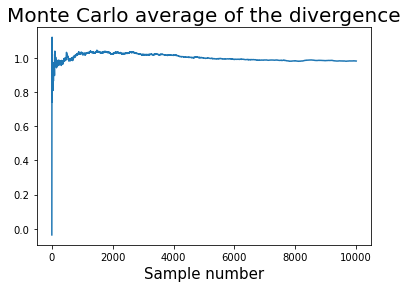

In [78]:
plt.plot(avgs)
plt.xlabel('Sample number', fontsize = 15)
plt.title('Monte Carlo average of the divergence', fontsize = 20)

In [79]:
np.save('avgs', avgs)

In [52]:
data = np.load('train_dataset.npy')
x_init = torch.squeeze(torch.tensor(data[0]))